In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install moabb> /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
dask-expr 1.0.11 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
featuretools 1.30.0 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
mizani 0.11.1 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.9.2 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible

In [3]:
import moabb

m_dataset = moabb.datasets.bi2013a(
    NonAdaptive=True,
    Adaptive=True,
    Training=True,
    Online=True,
)

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
2024-04-22 00:21:43.789172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 00:21:43.789482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempt

To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


/opt/conda/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [4]:
import warnings
warnings.filterwarnings('ignore')

m_dataset.download()

MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


100%|████████████████████████████████████████| 265M/265M [00:00<00:00, 174GB/s]
SHA256 hash of downloaded file: 8c0c9cb3e3345247430d5945e91c645bffa4074f79a196ac911aefde67a0acc1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|████████████████████████████████████████| 244M/244M [00:00<00:00, 118GB/s]
SHA256 hash of downloaded file: 25538b1956e0ac212a60fefaea9187171de19934637d72025120ddd45f363907
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|███████████████████████████████████████| 136M/136M [00:00<00:00, 86.7GB/s]
SHA256 hash of downloaded file: e71a1511ad839b7c93aab9f5dc2134a90e6d5a2a4d2546febcc11a6c9c1b856f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|████████████████████████████████

In [5]:
import gc
gc.collect()

53

In [6]:
m_data = m_dataset.get_data()

In [7]:
m_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [8]:
import sys
sys.getsizeof(m_data)

1176

In [39]:
import numpy as np
from scipy import signal
from sklearn.base import BaseEstimator, TransformerMixin


class Transformer(BaseEstimator, TransformerMixin):
    '''
    Base class for transformers providing dummy implementation
        of the methods expected by sklearn
    '''
    def fit(self, x, y=None):
        return self


class ButterFilter(Transformer):
    '''Applies Scipy's Butterworth filter'''
    def __init__(self, sampling_rate: int, order: int, highpass: int, lowpass: int) -> None:
        self.sampling_rate = sampling_rate
        self.order = order
        self.highpass = highpass
        self.lowpass = lowpass

        normal_cutoff = [a / (0.5 * self.sampling_rate) for a in (self.highpass, self.lowpass)]
        self.filter = signal.butter(self.order, normal_cutoff, btype='bandpass')

    def transform(self, x):
        out = np.empty_like(x)
        out[:] = [signal.filtfilt(*self.filter, item) for item in x]
        return out


class Decimator(Transformer):
    def __init__(self, factor: int):
        '''
        factor: downsampling factor, shouldn't be more than 13,
            see :py:funct:`scipy.signal.decimate` for more info
        '''
        self.factor = factor

    def transform(self, x):
        '''
        Args:
            x: iterable of np.ndarrays
        Returns:
            np.ndarray of np.objects shaped (len(x), )
                In other words it outputs ndarray of objects each of which is
                result of decimation of items from x
        '''
        out = np.empty(len(x), dtype=np.object)
        out[:] = [signal.decimate(item, self.factor) for item in x]
        return out


class ChannellwiseScaler(Transformer):
    '''Performs channelwise scaling according to given scaler
    '''
    def __init__(self, scaler: Transformer):
        '''Args:
            scaler: instance of one of sklearn.preprocessing classes
                StandardScaler or MinMaxScaler or analogue
        '''
        self.scaler = scaler

    def fit(self, x: np.ndarray, y=None):
        '''
        Args:
            x: array of eegs, that is every element of x is (n_channels, n_ticks)
                x shaped (n_eegs) of 2d array or (n_eegs, n_channels, n_ticks)
        '''
        for signals in x:
            self.scaler.partial_fit(signals.T)
        return self

    def transform(self, x):
        '''Scales each channel

        Wors either with one record, 2-dim input, (n_channels, n_samples)
            or many records 3-dim, (n_records, n_channels, n_samples)
        Returns the same format as input
        '''
        scaled = np.empty_like(x)
        for i, signals in enumerate(x):
            # double T for scaling each channel separately
            scaled[i] = self.scaler.transform(signals.T).T
        return scaled


class MarkersTransformer(Transformer):
    '''Transforms markers channels to arrays of indexes of epoch start and labels
    '''
    def __init__(self, labels_mapping: dict, decimation_factor: int=1, empty_label: float=0.):
        self.labels_mapping = labels_mapping
        self.decimation_factor = decimation_factor
        self.empty_label = empty_label

    def transform(self, batch):
        res = []
        for markers in batch:
            index_label = []
            for index, label in enumerate(markers):
                if label == self.empty_label: continue
                index_label.append([
                    index // self.decimation_factor,
                    self.labels_mapping[label],
                ])
            res.append(np.array(index_label, dtype=np.int))
        return res


In [40]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import mne


def mne_arrays(
    bin_epochs: list,
    rate: int,
    ch_set: list,
):
    info = mne.create_info(
        ch_names=ch_set,
        ch_types=['eeg']*len(ch_set),
        sfreq=rate,
        montage=mne.channels.read_montage(kind='easycap-M1'),
    )

    epochs = np.concatenate([i[0] for i in bin_epochs])
    events = np.concatenate([i[1] for i in bin_epochs])
    events = np.c_[np.arange(len(events)), events, events]

    epochs_array = mne.EpochsArray(data=epochs, info=info, events=events, verbose=False)
    evoked_nontarget = epochs_array['0'].average()
    evoked_target_raw = copy.deepcopy(epochs_array['1']).average()

    epochs_delta = epochs_array['1'].subtract_evoked(evoked=evoked_nontarget)
    evoked_target_delta = copy.deepcopy(epochs_delta).average()

    return {
        'target': evoked_target_raw,
        'nontarget': evoked_nontarget,
        'delta': evoked_target_delta,
    }


def plot_evoked_electrodes(
    bin_epochs: list,
    rate: int,
    ch_set: list,
    title: str='',
    figsize: tuple=(16, 10),
):
    '''Plots averaged evoked potentials from labeled binary epochs data

    Args:
        bin_epochs: data in format of `P300Dataset.binary_epochs`
        rate: rate of given signal
        ch_set: list of names of channels

    Returns:
        figure epochs plotted on
    '''
    colors = {
        'target': 'red',
        'nontarget': 'blue',
        'delta': 'black',
    }

    data = mne_arrays(bin_epochs, rate, ch_set)
    info = mne.create_info(
        ch_names=ch_set,
        ch_types=['eeg']*len(ch_set),
        sfreq=rate,
        montage=mne.channels.read_montage(kind='easycap-M1'),
    )

    # plot data
    fig = plt.figure(figsize=figsize)
    topo_iterator = mne.viz.topo.iter_topography(info, fig=fig, layout_scale=0.945,
                        fig_facecolor='w', axis_facecolor='w', axis_spinecolor='w')
    for axis, channel in topo_iterator:
        for name, value in data.items():
            axis.plot(value.times, value.data[channel], color=colors[name], label=name)
        axis.axhline(0, color='black', linewidth=1)
        axis.grid()
        axis.set_title(ch_set[channel])

    fig.axes[0].legend(prop={'size': 10}, loc=(-0.4, 0.1))
    fig.suptitle(title, fontsize=20)


def plot_evoked_map(
    bin_epochs: list,
    rate: int,
    ch_set: list,
):
    target = mne_arrays(bin_epochs, rate, ch_set)['target']
    target.plot_topomap()

def plot_evoked_joint(
    bin_epochs: list,
    rate: int,
    ch_set: list,
):
    target = mne_arrays(bin_epochs, rate, ch_set)['target']
    target.plot_joint()


In [11]:
# print(m_data[1]['session_1']['run_1'])
# channels = m_data[1]['session_1']['run_1'].ch_names[:-1]
# channels

KeyError: 'session_1'

In [12]:
# raw_dataset = []

# for _, sessions in sorted(m_data.items()):
#     eegs, markers = [], []
#     for item, run in sorted(sessions['session_1'].items()):
#         data = run.get_data()
#         eegs.append(data[:-1])
#         markers.append(data[-1])
#     raw_dataset.append((eegs, markers))

KeyError: 'session_1'

In [13]:
type(m_data)

dict

In [14]:
m_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [15]:
m_data[1]

{'1': {'0': <RawArray | 17 x 132896 (259.6 s), ~17.3 MB, data loaded>,
  '1': <RawArray | 17 x 104640 (204.4 s), ~13.6 MB, data loaded>,
  '2': <RawArray | 17 x 138784 (271.1 s), ~18.0 MB, data loaded>,
  '3': <RawArray | 17 x 106528 (208.1 s), ~13.8 MB, data loaded>},
 '4': {'0': <RawArray | 17 x 133504 (260.7 s), ~17.3 MB, data loaded>,
  '1': <RawArray | 17 x 114048 (222.7 s), ~14.8 MB, data loaded>,
  '2': <RawArray | 17 x 129184 (252.3 s), ~16.8 MB, data loaded>,
  '3': <RawArray | 17 x 99776 (194.9 s), ~13.0 MB, data loaded>},
 '6': {'0': <RawArray | 17 x 127072 (248.2 s), ~16.5 MB, data loaded>,
  '1': <RawArray | 17 x 104576 (204.2 s), ~13.6 MB, data loaded>,
  '2': <RawArray | 17 x 128864 (251.7 s), ~16.7 MB, data loaded>,
  '3': <RawArray | 17 x 151680 (296.2 s), ~19.7 MB, data loaded>},
 '0': {'0': <RawArray | 17 x 159232 (311.0 s), ~20.7 MB, data loaded>,
  '1': <RawArray | 17 x 125184 (244.5 s), ~16.3 MB, data loaded>,
  '2': <RawArray | 17 x 139552 (272.6 s), ~18.1 MB, da

In [16]:
print(m_data[1]['1']['0'])
channels = m_data[1]['1']['0'].ch_names[:-1]
channels

<RawArray | 17 x 132896 (259.6 s), ~17.3 MB, data loaded>


['Fp1',
 'Fp2',
 'F5',
 'AFz',
 'F6',
 'T7',
 'Cz',
 'T8',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'O1',
 'Oz',
 'O2']

In [22]:
raw_dataset = []

for _, sessions in sorted(m_data.items()):
    eegs, markers = [], []
    for item, run in sorted(sessions[sorted(sessions.keys())[0]].items()):
        data = run.get_data()
        eegs.append(data[:-1])
        markers.append(data[-1])
    raw_dataset.append((eegs, markers))

In [23]:
raw_sample = raw_dataset[0][0][0]
len(raw_dataset), len(raw_dataset[0]), len(raw_dataset[0][0]), raw_dataset[0][0][0].shape

(24, 2, 4, (16, 159232))

In [29]:
# m_data=None
# m_dataset =None
# gc.collect()

4622

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
sampling_rate = 512
decimation_factor = 10
final_rate = sampling_rate // decimation_factor
epoch_duration = 0.9 # seconds
labels_mapping = {33285.: 1, 33286.: 0}
captions = {0: 'empty', 1: 'target'}
np.object = object    
eeg_pipe = make_pipeline(
    Decimator(decimation_factor),
    ButterFilter(sampling_rate // decimation_factor, 4, 0.5, 20),
    ChannellwiseScaler(StandardScaler()),
)
markers_pipe = MarkersTransformer(labels_mapping, decimation_factor)

In [42]:
for eegs, _ in raw_dataset:
    eeg_pipe.fit(eegs)

In [43]:
dataset = []
epoch_count = int(epoch_duration * final_rate)
np.int = int    
np.float = float    
np.bool = bool    
for eegs, markers in raw_dataset:
    epochs = []
    labels = []
    filtered = eeg_pipe.transform(eegs)
    markups = markers_pipe.transform(markers)
    for signal_t, markup in zip(filtered, markups):
        epochs.extend([signal_t[:, start:(start + epoch_count)] for start in markup[:, 0]])
        labels.extend(markup[:, 1])
    dataset.append((np.array(epochs), np.array(labels)))

ValueError: The number of FixedLocator locations (16), usually from a call to set_ticks, does not match the number of labels (32).

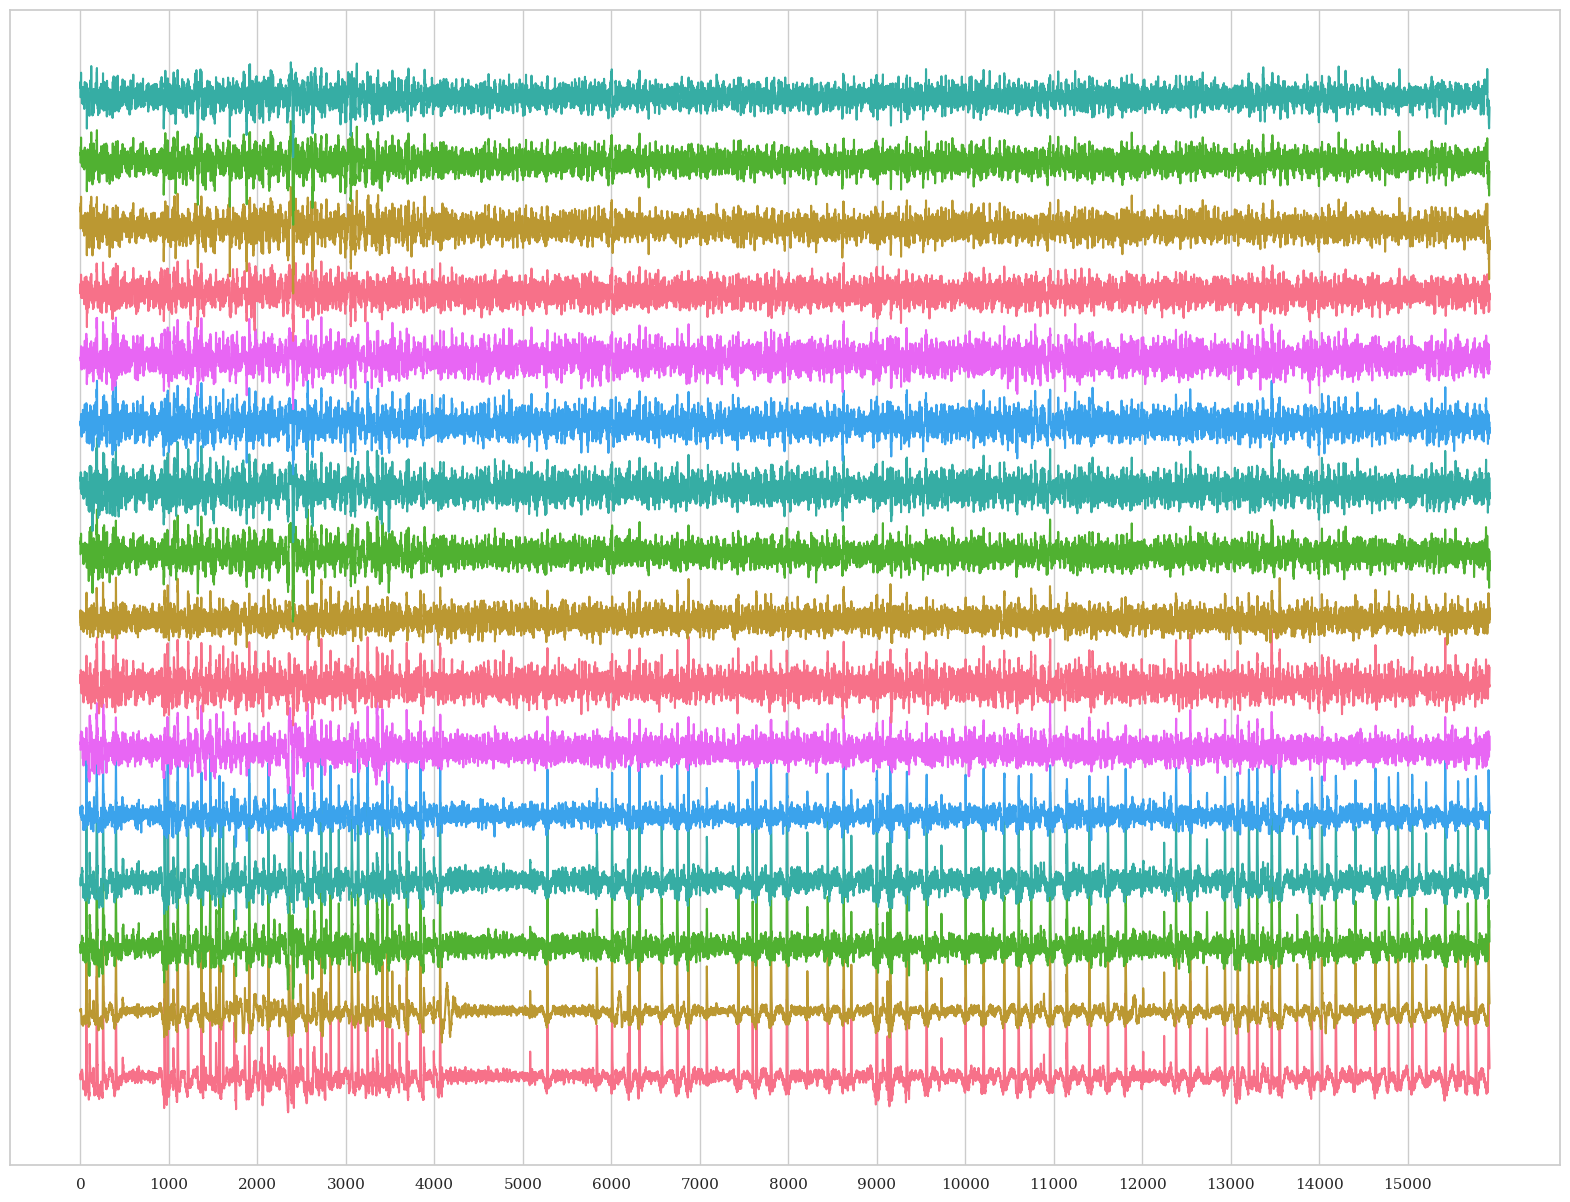

In [44]:
epoch = eeg_pipe.fit_transform([raw_sample])[0]
plt.figure(figsize=(20, 15))
plt.plot(epoch.T + np.arange(len(epoch))*5)
plt.yticks([])
plt.xticks(np.arange(0, 16000, 1000), np.arange(0, 32, 1))
plt.xlabel('seconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.title('Filtered EEG signal of one run of the game')
plt.show()

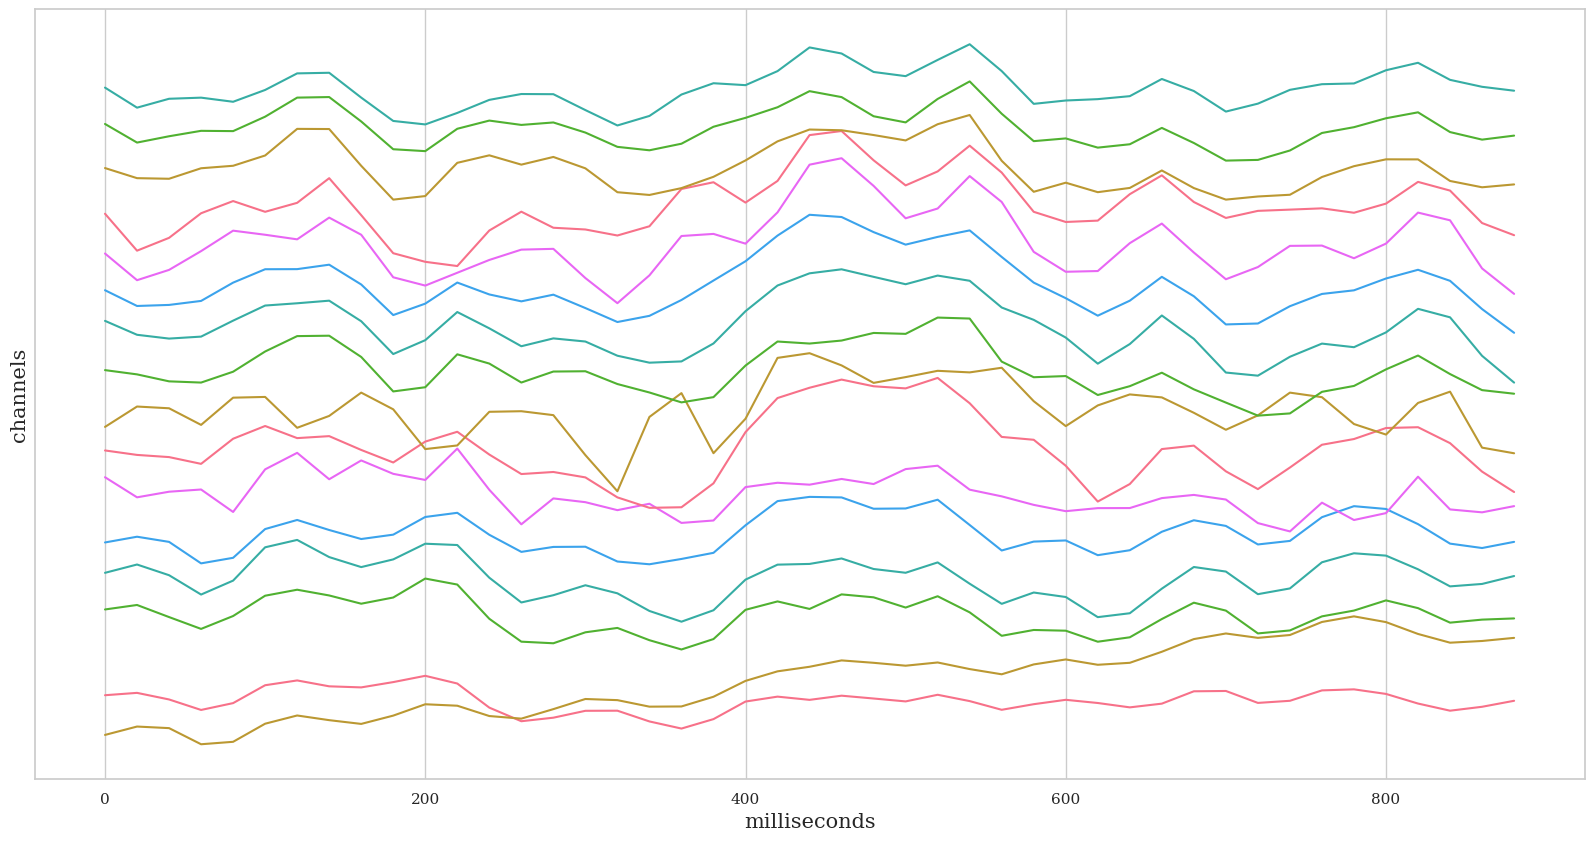

In [45]:
epoch = dataset[0][0][0]
plt.figure(figsize=(20, 10))
plt.plot(epoch.T + np.arange(len(epoch)))
plt.yticks([])
plt.xticks(np.arange(0, 50, 10), np.arange(0, 1000, 200))
plt.xlabel('milliseconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.show()

In [46]:
all_epochs = np.concatenate([epochs for epochs, _ in dataset])
all_epochs.shape, all_epochs.dtype

((34872, 16, 45), dtype('float64'))

5.0


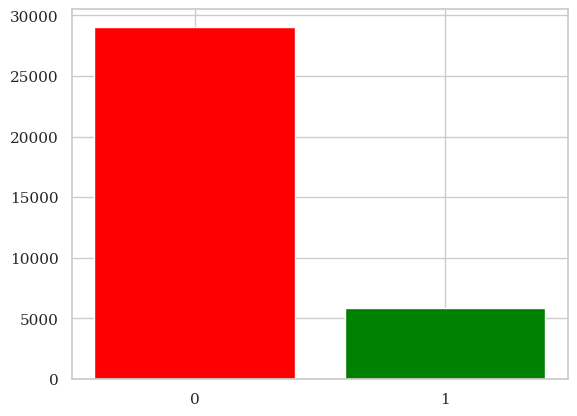

In [47]:
all_labels = np.concatenate([labels for _, labels in dataset])

uniques, counts = np.unique(all_labels, return_counts=True)

plt.bar(uniques, counts, color=['r', 'g'])
plt.xticks(uniques)

print(counts[0] / counts[1])

In [48]:
def plot_by_labels(epochs, labels):
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    for label in (0, 1):
        mean = epochs[labels == label].mean(axis=(0, 1))
        std = epochs[labels == label].std(axis=(0, 1))

        axes[0].plot(mean, label=captions[label])

        axes[1].plot(mean, label=captions[label])
        axes[1].fill_between(np.arange(mean.size), mean-std, mean+std, alpha=0.25)

    axes[0].legend(fontsize=20)
    axes[0].set_ylim(-0.16, 0.26)
    axes[1].set_ylim(-0.8, 0.85)
    for i, title in enumerate(('Means', 'Means with Stds')):
        axes[i].set_title(title, fontsize=20)
        axes[i].set_xticklabels(np.arange(-200, 1000, 200))
        axes[i].set_xlabel('milliseconds')

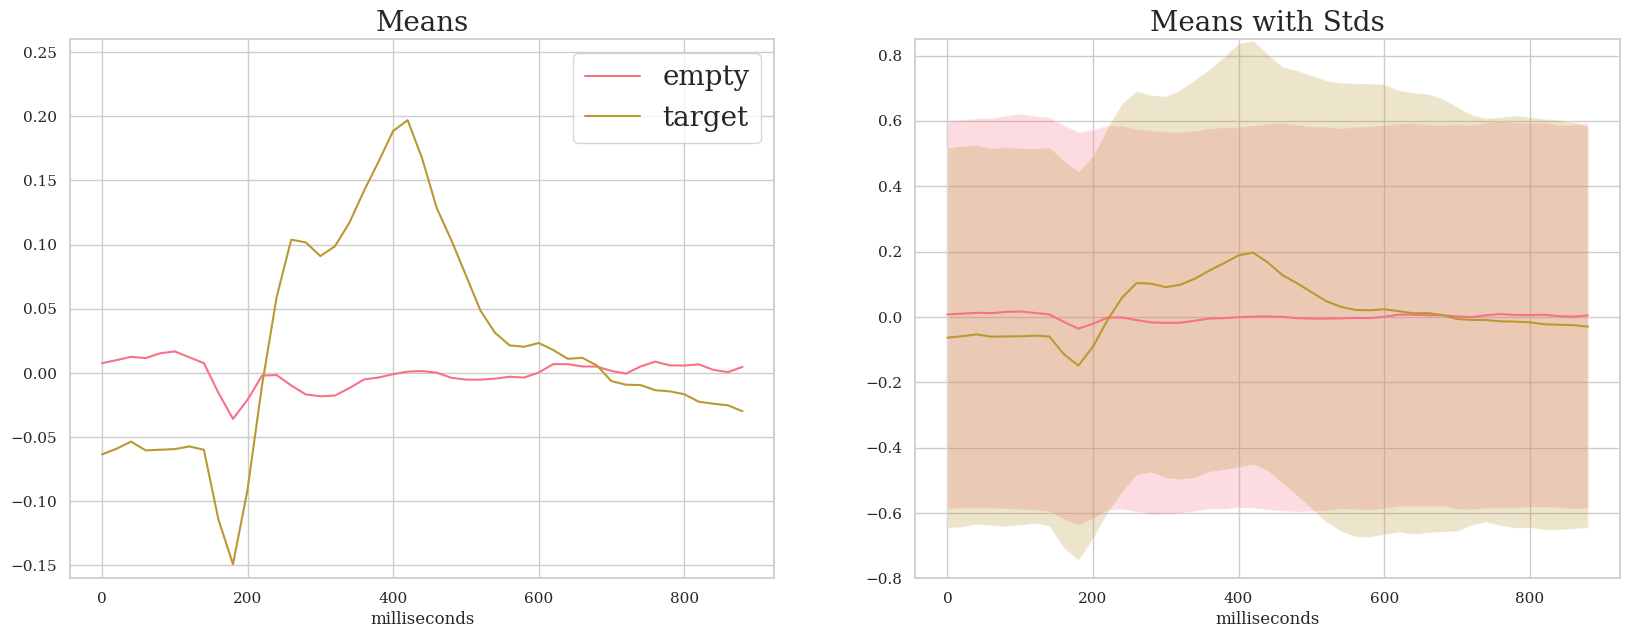

In [49]:
plot_by_labels(all_epochs, all_labels)

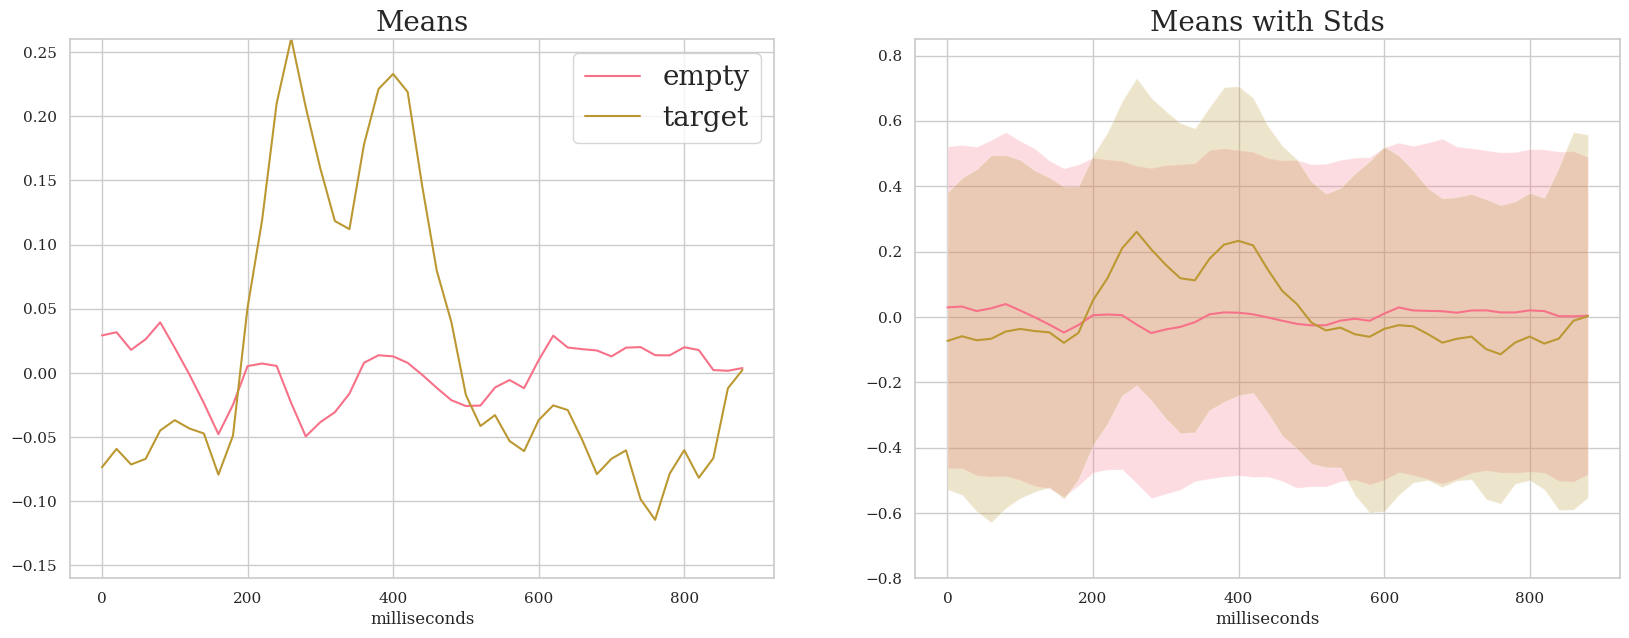

In [50]:
plot_by_labels(dataset[6][0], dataset[6][1])

In [53]:
len(dataset)

24

In [54]:
len(dataset[0])

2

In [56]:
type(dataset[0])

tuple

In [57]:
for i in dataset:
    print(len(i),type(i))

2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>


In [59]:
for i in dataset:
    print(i[0].dtype,i[0].shape,i[1].dtype,i[1].shape)

float64 (1308, 16, 45) int64 (1308,)
float64 (1536, 16, 45) int64 (1536,)
float64 (1560, 16, 45) int64 (1560,)
float64 (1332, 16, 45) int64 (1332,)
float64 (1404, 16, 45) int64 (1404,)
float64 (1476, 16, 45) int64 (1476,)
float64 (1344, 16, 45) int64 (1344,)
float64 (1524, 16, 45) int64 (1524,)
float64 (1356, 16, 45) int64 (1356,)
float64 (1584, 16, 45) int64 (1584,)
float64 (1512, 16, 45) int64 (1512,)
float64 (1560, 16, 45) int64 (1560,)
float64 (1620, 16, 45) int64 (1620,)
float64 (1344, 16, 45) int64 (1344,)
float64 (1284, 16, 45) int64 (1284,)
float64 (1344, 16, 45) int64 (1344,)
float64 (1464, 16, 45) int64 (1464,)
float64 (1272, 16, 45) int64 (1272,)
float64 (1560, 16, 45) int64 (1560,)
float64 (1488, 16, 45) int64 (1488,)
float64 (1308, 16, 45) int64 (1308,)
float64 (1500, 16, 45) int64 (1500,)
float64 (1752, 16, 45) int64 (1752,)
float64 (1440, 16, 45) int64 (1440,)


16 каналов по 45 значений  

In [61]:
dataset1 = copy.copy(dataset)

In [62]:
dataset2 = [(i[0].reshape(i[0].shape[0],16*45),i[1]) for i in dataset1]

In [63]:
for i in dataset2:
    print(i[0].dtype,i[0].shape,i[1].dtype,i[1].shape)

float64 (1308, 720) int64 (1308,)
float64 (1536, 720) int64 (1536,)
float64 (1560, 720) int64 (1560,)
float64 (1332, 720) int64 (1332,)
float64 (1404, 720) int64 (1404,)
float64 (1476, 720) int64 (1476,)
float64 (1344, 720) int64 (1344,)
float64 (1524, 720) int64 (1524,)
float64 (1356, 720) int64 (1356,)
float64 (1584, 720) int64 (1584,)
float64 (1512, 720) int64 (1512,)
float64 (1560, 720) int64 (1560,)
float64 (1620, 720) int64 (1620,)
float64 (1344, 720) int64 (1344,)
float64 (1284, 720) int64 (1284,)
float64 (1344, 720) int64 (1344,)
float64 (1464, 720) int64 (1464,)
float64 (1272, 720) int64 (1272,)
float64 (1560, 720) int64 (1560,)
float64 (1488, 720) int64 (1488,)
float64 (1308, 720) int64 (1308,)
float64 (1500, 720) int64 (1500,)
float64 (1752, 720) int64 (1752,)
float64 (1440, 720) int64 (1440,)


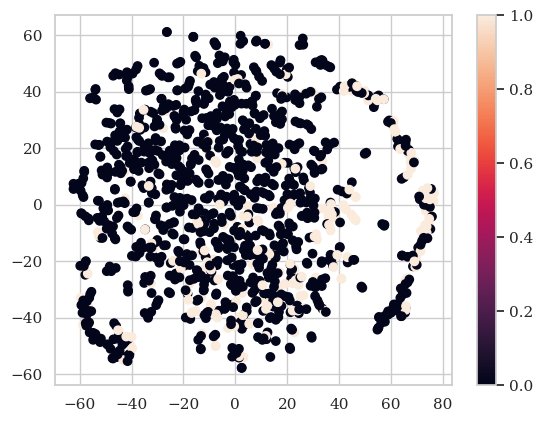

In [67]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=6.0)
X_embedded = tsne.fit_transform(dataset2[0][0])
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c=dataset2[0][1])
plt.colorbar()
plt.show()

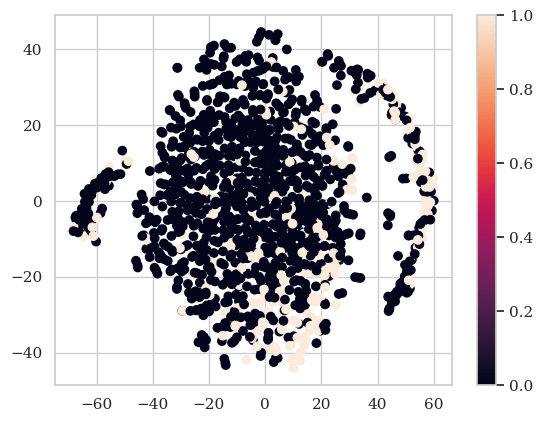

In [69]:
tsne = TSNE(n_components=2,perplexity=15.0)
X_embedded = tsne.fit_transform(dataset2[0][0])
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c=dataset2[0][1])
plt.colorbar()
plt.show()

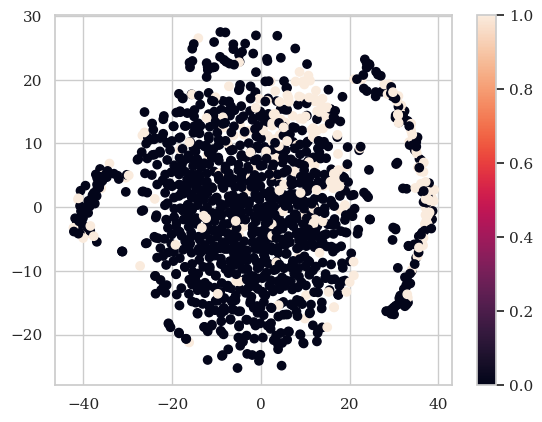

In [70]:
tsne = TSNE(n_components=2,perplexity=30.0)
X_embedded = tsne.fit_transform(dataset2[0][0])
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c=dataset2[0][1])
plt.colorbar()
plt.show()

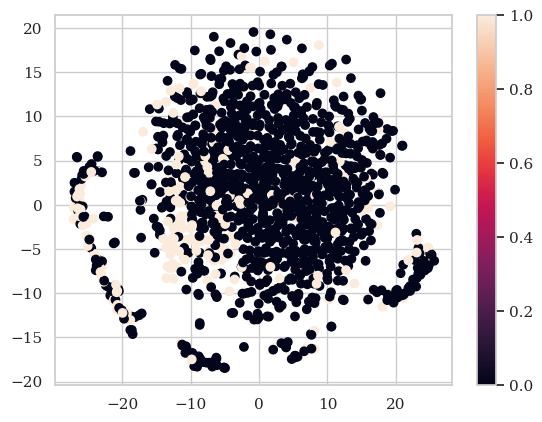

In [71]:
tsne = TSNE(n_components=2,perplexity=45.0)
X_embedded = tsne.fit_transform(dataset2[0][0])
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c=dataset2[0][1])
plt.colorbar()
plt.show()

In [105]:
from tqdm import tqdm
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

class SVM:
    def __init__(self, kernel='linear', C=10, max_iter=100, degree=3, gamma=1):
        self.kernel = {'poly':lambda x,y: np.dot(x, y.T)**degree,
                       'rbf':lambda x,y:np.exp(-gamma*np.sum((y-x[:,np.newaxis])**2,axis=-1)),
                       'linear':lambda x,y: np.dot(x, y.T)}[kernel]
        self.C = C
        self.max_iter = max_iter

    def restrict_to_square(self, t, v0, u):
        t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
        return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y * 2 - 1
        self.lambdas = np.zeros_like(self.y, dtype=float)
        self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y

        for _ in tqdm(range(self.max_iter)):
            for idxM in range(len(self.lambdas)):
                idxL = np.random.randint(0, len(self.lambdas))
                Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
                v0 = self.lambdas[[idxM, idxL]]
                k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
                u = np.array([-self.y[idxL], self.y[idxM]])
                t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
                self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
                
        idx, = np.nonzero(self.lambdas > 1E-15)
        self.b = np.sum((1.0-np.sum(self.K[idx]*self.lambdas, axis=1))*self.y[idx])/len(idx)
        return self
        
    def predict(self, X):
        return (self.predict_proba(X)>0.5).astype(int)
    def predict_proba(self, X):
        return sigmoid(np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b)


In [75]:
from sklearn.model_selection import train_test_split

In [76]:
X_data = dataset2[0][0]
y_data = dataset2[0][1]
x_train,x_test,y_train,y_test = train_test_split(X_data,y_data,test_size=0.2,random_state=42,stratify=y_data)

In [106]:
clf_test = SVM().fit(x_train,y_train)

y_pred = clf_test.predict(x_test)

100%|██████████| 100/100 [00:07<00:00, 13.89it/s]


In [107]:
y_pred[0],y_pred[1],y_pred[2],y_pred[3]

(0, 1, 0, 0)

In [89]:
y_test[0],y_test[1],y_test[2],y_test[3]

(0, 1, 0, 0)

In [111]:
from sklearn.metrics import f1_score,accuracy_score
accuracy_score(y_test,y_pred),f1_score(y_test,y_pred)

(0.9465648854961832, 0.8510638297872342)

In [112]:
clf_test = SVM(max_iter=10).fit(x_train,y_train)

y_pred = clf_test.predict(x_test)
accuracy_score(y_test,y_pred),f1_score(y_test,y_pred)

100%|██████████| 10/10 [00:00<00:00, 12.82it/s]


(0.9618320610687023, 0.888888888888889)

In [113]:
clf_test = SVM(max_iter=5).fit(x_train,y_train)

y_pred = clf_test.predict(x_test)
accuracy_score(y_test,y_pred),f1_score(y_test,y_pred)

100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


(0.9198473282442748, 0.7835051546391751)

In [116]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    params = {
        "kernel":trial.suggest_categorical("kernel",['linear', 'rbf','poly']),
        "C": trial.suggest_float('C', 1, 10),
        "max_iter": trial.suggest_int("max_iter", 3,20) ,
    }
    if params['kernel'] == 'poly':
        params['degree'] = trial.suggest_int("degree", 2,5) 
    if params['kernel'] == 'rbf':
        params['gamma'] = trial.suggest_float("gamma", 0.5,1.5) 

    clf = SVM(**params)
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    return f1_score(y_test,y_pred)
    

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600, n_jobs=2)

In [120]:
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)

Number of finished trials: 100
  Value: 0.8988764044943819
{'kernel': 'linear', 'C': 9.874421412717068, 'max_iter': 20}
